# EDA

## Config

In [1]:
from recognizer.utils.constants import ROOT_DIR, ALL_DATASET_DIR
from recognizer.utils.utils import get_metadata_from_filename

In [2]:
import os

targets = []
subjects = []
repetitions = []
files = []

for file in os.listdir(ALL_DATASET_DIR):
    if "left" in file:
        continue

    target, subject, repetition = get_metadata_from_filename(file)

    targets.append(target)
    subjects.append(subject)
    repetitions.append(repetition)
    files.append(str((ALL_DATASET_DIR / file).resolve()))

In [3]:
import pandas as pd 

metadata = pd.DataFrame(
    data={
        "target": targets,
        "subject": subjects,
        "repetition": repetitions,
        "file": files,
    }
)

metadata.head()

,target,subject,repetition,file
0,008,010,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...
1,023,001,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...
2,039,003,005,/Users/facundopalavecino/Documents/DEV/ecd-tra...
3,051,005,002,/Users/facundopalavecino/Documents/DEV/ecd-tra...
4,010,007,001,/Users/facundopalavecino/Documents/DEV/ecd-tra...


In [4]:
from recognizer.utils.constants import TARGET_TO_WORD_ES

metadata["label"] = metadata.target.map(TARGET_TO_WORD_ES)

## Distribution of classes

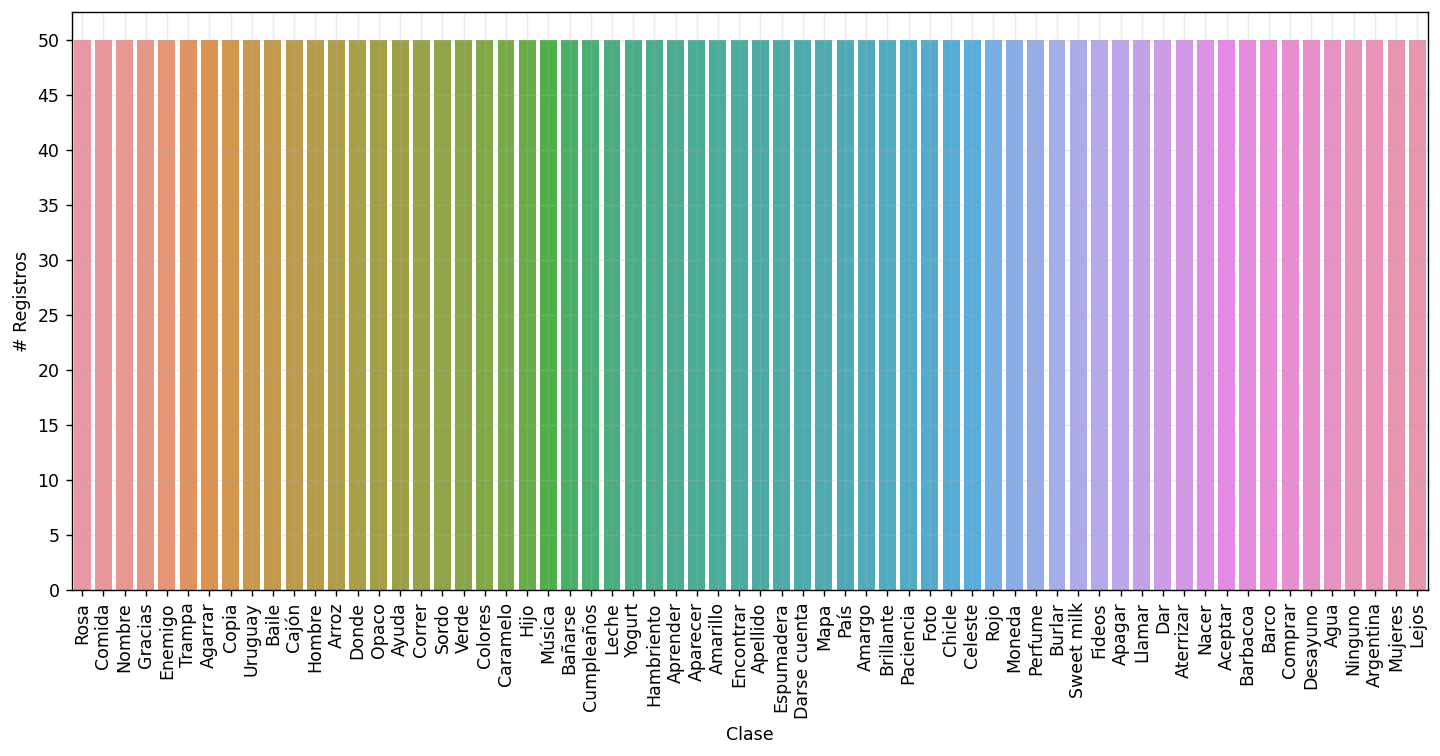

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, facecolor="white", dpi=125, figsize=(14, 6))

#ax.set_title("Número de registros por clase")

sns.countplot(data=metadata, x="label", ax=ax)

ax.set_xlabel("Clase")
ax.set_ylabel("# Registros")

ax.set_yticks(np.arange(0, 55, 5))

plt.xticks(rotation=90)

ax.grid(alpha=0.25)

In [7]:
import cv2

from typing import Tuple

def get_video_frame_size(path_fo_video_file: str) -> Tuple[float, float]:
    video = cv2.VideoCapture(path_fo_video_file)

    width = video.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)

    return height, width

In [8]:
metadata.loc[:, "tuples"] = metadata["file"].apply(get_video_frame_size)

metadata[["height", "width"]] = pd.DataFrame(metadata['tuples'].tolist(), index=metadata.index)

metadata.drop(labels=["tuples"], axis=1, inplace=True)

metadata.head()

,target,subject,repetition,file,label,height,width
0,008,010,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...,Rosa,1080.0,1920.0
1,023,001,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...,Comida,1080.0,1920.0
2,039,003,005,/Users/facundopalavecino/Documents/DEV/ecd-tra...,Nombre,1080.0,1920.0
3,051,005,002,/Users/facundopalavecino/Documents/DEV/ecd-tra...,Gracias,1080.0,1920.0
4,010,007,001,/Users/facundopalavecino/Documents/DEV/ecd-tra...,Enemigo,1080.0,1920.0


In [10]:
pd.DataFrame(
    [
        metadata.height.describe(percentiles=[.1, .25, .5, .75, .9, .99]),
        metadata.width.describe(percentiles=[.1, .25, .5, .75, .9, .99]),
    ]
)

,count,mean,std,min,10%,25%,50%,75%,90%,99%,max
height,3200.0,1080.0,0.0,1080.0,1080.0,1080.0,1080.0,1080.0,1080.0,1080.0,1080.0
width,3200.0,1920.0,0.0,1920.0,1920.0,1920.0,1920.0,1920.0,1920.0,1920.0,1920.0


## Frames per video

We find that every video has equal FPS (59.94) but different duration.

In [11]:
import cv2

from typing import Tuple

def get_video_stats(path_fo_video_file: str) -> Tuple[float, float, float]:
    video = cv2.VideoCapture(path_fo_video_file)

    frames = video.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = video.get(cv2.CAP_PROP_FPS)

    return frames, fps, frames/fps

In [12]:
metadata.loc[:, "tuples"] = metadata["file"].apply(get_video_stats)

metadata[["frames", "fps", "duration"]] = pd.DataFrame(metadata['tuples'].tolist(), index=metadata.index)

metadata.drop(labels=["tuples"], axis=1, inplace=True)

metadata.head()

,target,subject,repetition,file,label,height,width,frames,fps,duration
0,008,010,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...,Rosa,1080.0,1920.0,148.0,59.94,2.469136
1,023,001,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...,Comida,1080.0,1920.0,148.0,59.94,2.469136
2,039,003,005,/Users/facundopalavecino/Documents/DEV/ecd-tra...,Nombre,1080.0,1920.0,152.0,59.94,2.535869
3,051,005,002,/Users/facundopalavecino/Documents/DEV/ecd-tra...,Gracias,1080.0,1920.0,122.0,59.94,2.035369
4,010,007,001,/Users/facundopalavecino/Documents/DEV/ecd-tra...,Enemigo,1080.0,1920.0,88.0,59.94,1.468135


In [13]:
pd.DataFrame(
    [
        metadata.frames.describe(percentiles=[.1, .25, .5, .75, .9, .99]),
        metadata.fps.describe(percentiles=[.1, .25, .5, .75, .9, .99]),
        metadata.duration.describe(percentiles=[.1, .25, .5, .75, .9, .99])
    ]
)

,count,mean,std,min,10%,25%,50%,75%,90%,99%,max
frames,3200.0,127.781250,2.664205e+01,58.000000,88.000000,118.000000,122.000000,152.000000,152.000000,212.00000,242.000000
fps,3200.0,59.940000,2.131961e-14,59.940000,59.940000,59.940000,59.940000,59.940000,59.940000,59.94000,59.940000
duration,3200.0,2.131819,4.444787e-01,0.967634,1.468135,1.968635,2.035369,2.535869,2.535869,3.53687,4.037371


In [24]:
metadata.frames.std()

26.642052484984927

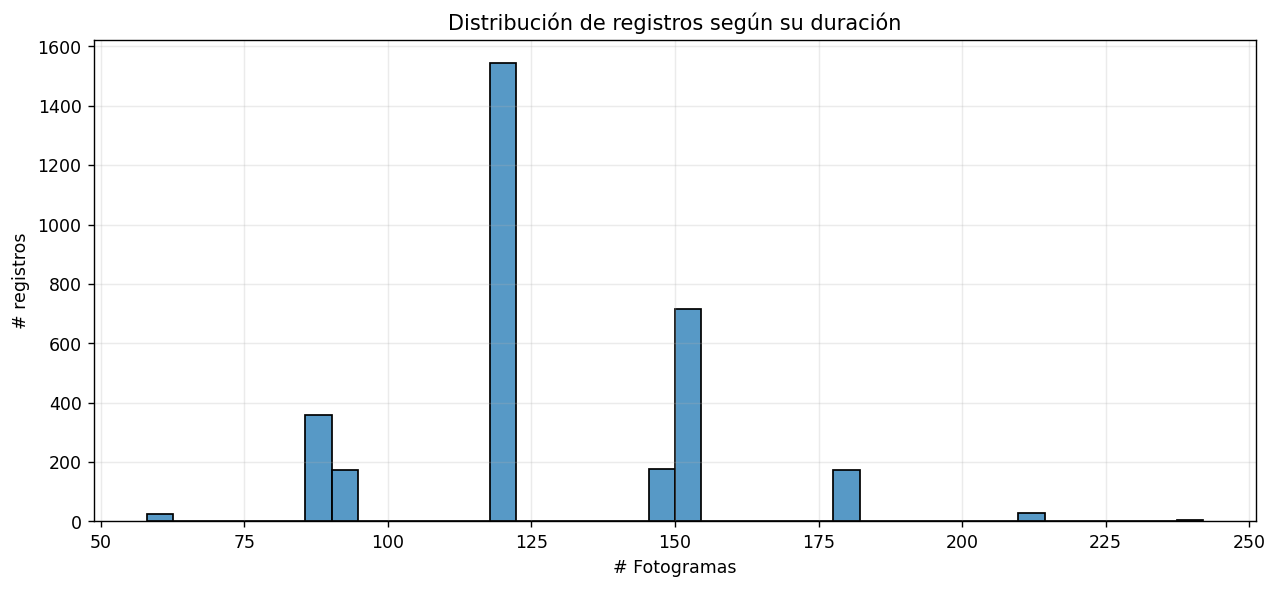

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), facecolor="white", dpi=125)

sns.histplot(data=metadata, x="frames", ax=ax, kde=False)

ax.set_title("Distribución de registros según su duración")
ax.set_xlabel("# Fotogramas")
ax.set_ylabel("# registros")

plt.grid(alpha=0.25)

## Average frames for each class

Some (words) classes have more frames on average than others

In [20]:
frames_by_target = (
    metadata.groupby(by=["target"])["frames"]
    .agg(["min", "max", "mean", "std"])
    .reset_index()
    .sort_values("mean", ascending=False)
)

frames_by_target.head()

,target,min,max,mean,std
33,034,152.0,242.0,197.0,22.879453
40,041,152.0,212.0,173.6,19.204591
44,045,122.0,212.0,161.0,18.433554
30,031,92.0,212.0,161.0,20.328928
5,006,88.0,208.0,154.6,20.365036


In [25]:
frames_by_target.tail()

,target,min,max,mean,std,label
16,017,58.0,118.0,98.2,16.719779,Llamar
19,020,58.0,118.0,97.6,17.607976,Sweet milk
13,014,58.0,118.0,94.0,20.101782,Cajón
14,015,58.0,178.0,92.8,22.967590,Nacer
18,019,58.0,118.0,91.6,14.393876,Amargo


In [21]:
frames_by_target["label"] = frames_by_target.target.map(TARGET_TO_WORD_ES)

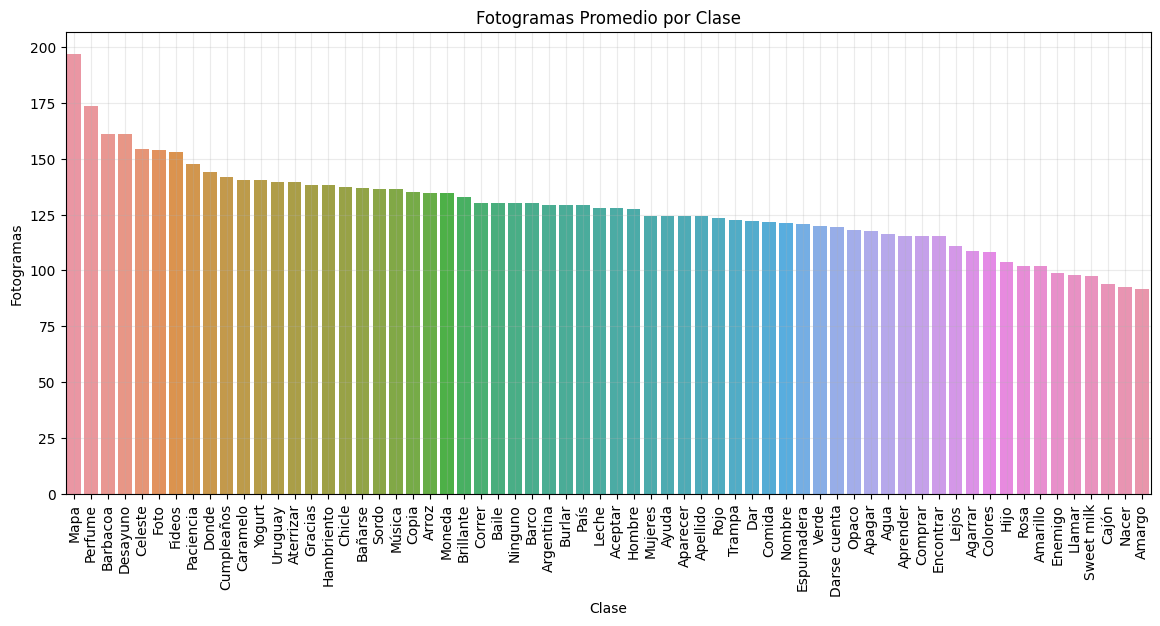

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

sns.barplot(data=frames_by_target, x="label", y="mean", ax=ax)

ax.set_title("Fotogramas Promedio por Clase")
ax.set_ylabel("Fotogramas")
ax.set_xlabel("Clase")

plt.xticks(rotation=90)

ax.grid(alpha=0.25)

In [17]:
duration_by_target = (
    metadata.groupby(by=["target"])["duration"]
    .agg(["min", "max", "mean", "std"])
    .reset_index()
    .sort_values(by=["mean"], ascending=False)
)

duration_by_target["label"] = duration_by_target.target.map(TARGET_TO_WORD_ES)

duration_by_target.head()

,target,min,max,mean,std,label
33,034,2.535869,4.037371,3.286620,0.381706,Mapa
40,041,2.535869,3.536870,2.896230,0.320397,Perfume
44,045,2.035369,3.536870,2.686019,0.307533,Barbacoa
30,031,1.534868,3.536870,2.686019,0.339155,Desayuno
5,006,1.468135,3.470137,2.579246,0.339757,Celeste


In [18]:
duration_by_target.tail()

,target,min,max,mean,std,label
16,017,0.967634,1.968635,1.638305,0.278942,Llamar
19,020,0.967634,1.968635,1.628295,0.293760,Sweet milk
13,014,0.967634,1.968635,1.568235,0.335365,Cajón
14,015,0.967634,2.969636,1.548215,0.383176,Nacer
18,019,0.967634,1.968635,1.528195,0.240138,Amargo


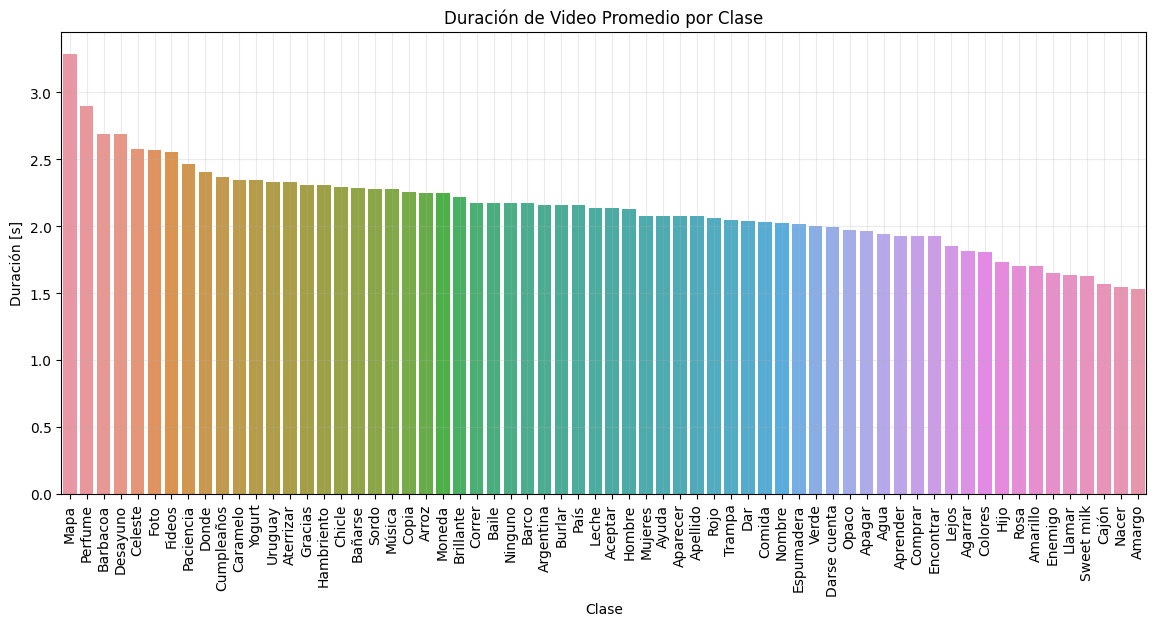

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

sns.barplot(data=duration_by_target, x="label", y="mean", ax=ax)

ax.set_title("Duración de Video Promedio por Clase")
ax.set_ylabel("Duración [s]")
ax.set_xlabel("Clase")

plt.xticks(rotation=90)

ax.grid(alpha=0.25)

## Distribución de sujeto, clase, repeticiones

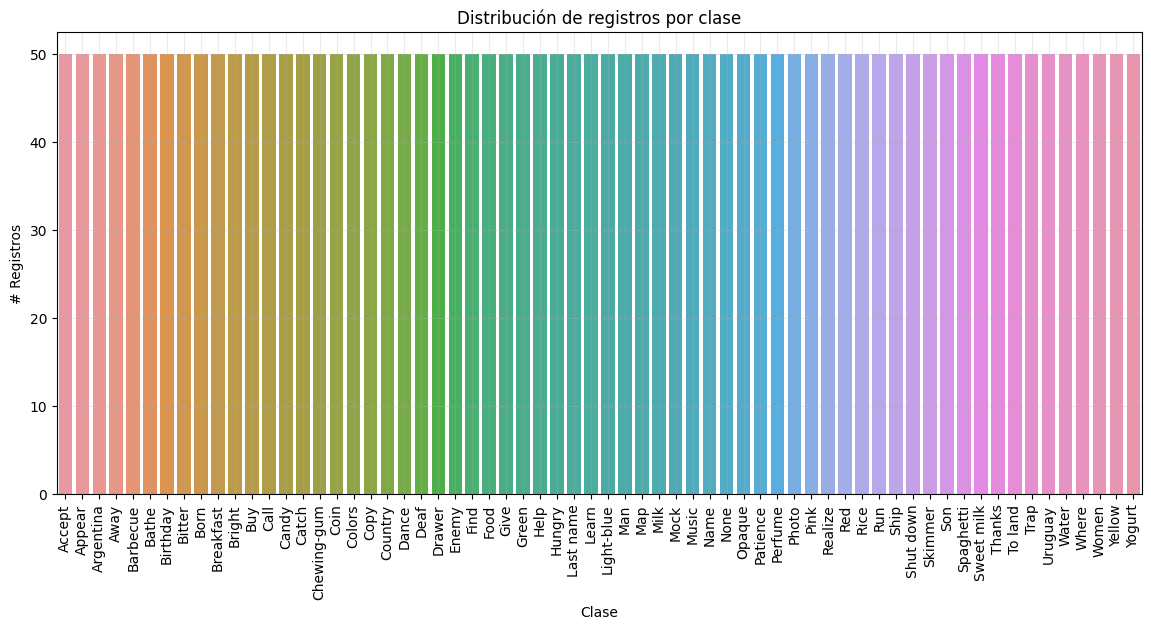

In [88]:
group_by_target = metadata.groupby(["label"])["target"].agg("count").reset_index()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

sns.barplot(data=group_by_target, x="label", y="target", ax=ax)

ax.set_title("Distribución de Registros por Clase")
ax.set_ylabel("# Registros")
ax.set_xlabel("Clase")

plt.xticks(rotation=90)

ax.grid(alpha=0.25)

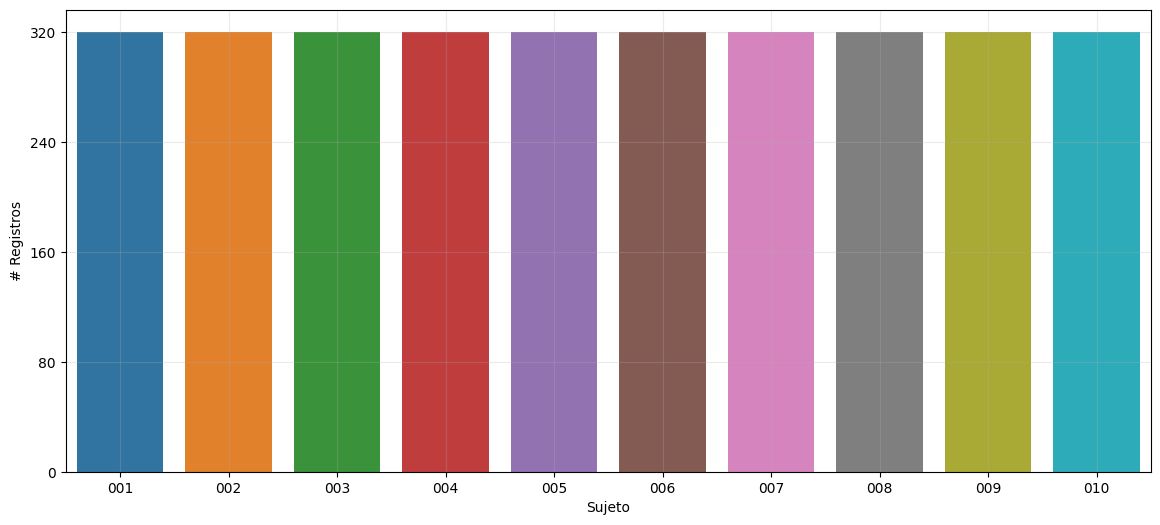

In [23]:
group_by_subject = metadata.groupby(["subject"])["label"].agg("count").reset_index()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

sns.barplot(data=group_by_subject, x="subject", y="label", ax=ax)

ax.set_ylabel("# Registros")
ax.set_xlabel("Sujeto")

ax.set_yticks(np.linspace(0, group_by_subject.label.max(), 5))
ax.grid(alpha=0.25)

In [101]:
repetitions_by_subject = metadata.groupby(["label", "subject"])["repetition"].agg("count").reset_index()

repetitions_by_subject.head()
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# sns.barplot(data=repetitions_by_subject, x="subject", y="label", ax=ax)

# ax.set_title("Distribución de videos por sujeto")
# ax.set_ylabel("# Registros")
# ax.set_xlabel("Sujeto")

# ax.set_yticks(np.linspace(0, group_by_subject.label.max(), 5))
# ax.grid(alpha=0.25)

,label,subject,repetition
0,Accept,001,5
1,Accept,002,5
2,Accept,003,5
3,Accept,004,5
4,Accept,005,5
